In [1]:
import os
import re
import copy
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.wcs import WCS
import matplotlib.animation as animation
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import Background2D, MedianBackground
from photutils import DAOStarFinder
from astropy.stats import mad_std
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
from astropy.table import Table
from scipy.optimize import curve_fit

data_folder = '/Volumes/Extreme SSD/COSMOS data'

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_88682/3543633224.py:13: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder


In [2]:
data_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/calibrated_with_WCS.fits'
data_file_2 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/calibrated_CMS_RS_M38_r_filter1000ms_-25C 2024 November 01 08_20_10.fits'
# data_file_2 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/Uncalibrated/CMS_RS_M38_r_filter1000ms_-25C 2024 November 01 08_20_10.fits'
dark_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/calibrated_CMS_RS_dark_1000ms_-25C 2024 October 31 21_36_05.fits'
defect_pix_file_1 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Defect Maps/defect_map_calibration_CMS.fits'
defect_pix_file_2 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Defect Maps/defect_map_dark_CMS.fits'
hdu = fits.open(data_file)[0]
wcs = WCS(hdu.header)
data = hdu.data
hdu2 = fits.open(data_file_2)[0]
data2 = hdu2.data.astype(int)
data = data2[1]
# data = np.mean(data2, axis=0)
dark_data = fits.getdata(dark_file).astype(int)
dark_data_avg = np.mean(dark_data, axis=0)
data = data - dark_data_avg
bkg_sigma = mad_std(data)  # Background standard deviation
defect_data_1 = fits.getdata(defect_pix_file_1)
defect_data_2 = fits.getdata(defect_pix_file_2)
defect_data_1[1257] = np.NaN
defect_data_1[6451] = np.NaN
defect_data_1[:,994] = np.NaN
data = data * defect_data_1 * defect_data_2
# Print the pixel scale
print(wcs.pixel_scale_matrix * 3600)
print(np.nanmedian(data))

[[ 0.31623023  0.1362374 ]
 [-0.1364428   0.31628791]]
3.5999999999999943


In [3]:
# Make the flat field correction
flat_field_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/calibrated_CMS_RS_SkyFlats_1000ms_-25_r_filter 2024 October 31 21_19_20.fits'
flat_field_data = fits.getdata(flat_field_file)
flat_field_mean_img = np.mean(flat_field_data, axis=0)
flat_field = (flat_field_mean_img - dark_data_avg) * defect_data_1 * defect_data_2
# Divide by the upper 0.5 percentile to normalize the flat field without outliers skewing the result
flat_field = flat_field / np.nanpercentile(flat_field, 99.5)
data = data / flat_field
# Turn NaNs into background value
print(np.nanmedian(data))
data = np.nan_to_num(data, nan=np.nanmedian(data))
data = data + 100

3.8114509180898777


In [4]:
daofind = DAOStarFinder(fwhm=3.0, threshold=100)
sources = daofind(data)
positions = [(x, y) for x, y in zip(sources['xcentroid'], sources['ycentroid'])]
# Define aperture and annulus radii
aperture_radius = 7  # pixels
annulus_inner_radius = 18  # pixels
annulus_outer_radius = 21  # pixels

# Create apertures and annuli
apertures = CircularAperture(positions, r=aperture_radius)
annuli = CircularAnnulus(positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Perform aperture photometry on the image
aperture_photometry_result = aperture_photometry(data, apertures)

# Perform background photometry using annuli
annulus_masks = annuli.to_mask(method='center')
background_medians = []

for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]  # Exclude zero-padding
    # Ignore warning for clipping NaNs
    _, median_background, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.0)
    background_medians.append(median_background)

# Subtract background and calculate final flux
aperture_sums = aperture_photometry_result['aperture_sum']
background_sums = np.array(background_medians) * apertures.area
final_fluxes = aperture_sums - background_sums

# Add results to the photometry table
aperture_photometry_result['RA'], aperture_photometry_result['DEC'] = wcs.all_pix2world(aperture_photometry_result['xcenter'], aperture_photometry_result['ycenter'], 0)
aperture_photometry_result['background'] = background_medians
aperture_photometry_result['final_flux'] = final_fluxes
# aperture_photometry_result = aperture_photometry_result[~np.isnan(aperture_photometry_result['final_flux'])]
aperture_photometry_result.sort('final_flux')
# Only keep those with positive final flux
aperture_photometry_result = aperture_photometry_result[aperture_photometry_result['final_flux'] > 0]
# Exclude stars within 50 pixels of the edge
aperture_photometry_result = aperture_photometry_result[(aperture_photometry_result['xcenter'] / u.pix > 50)]
aperture_photometry_result = aperture_photometry_result[(aperture_photometry_result['ycenter'] / u.pix > 50)]
aperture_photometry_result = aperture_photometry_result[(aperture_photometry_result['xcenter'] / u.pix < 8070)]
aperture_photometry_result = aperture_photometry_result[(aperture_photometry_result['ycenter'] / u.pix < 8070)]

# Print the results
print(aperture_photometry_result)

# # Exclude stars that are within 30 pixels of each other
# # Find distance to nearest star for each star
# distances = np.zeros(len(aperture_photometry_result))
# for i, entry in enumerate(aperture_photometry_result):
#     xpos = entry['xcenter']
#     ypos = entry['ycenter']
#     min_dist = 100
#     for j, entry2 in enumerate(aperture_photometry_result):
#         if i == j:
#             continue
#         xpos2 = entry2['xcenter']
#         ypos2 = entry2['ycenter']
#         distance = np.sqrt((xpos - xpos2) ** 2 + (ypos - ypos2) ** 2) / u.pix
#         if distance < min_dist:
#             min_dist = distance
#     distances[i] = min_dist
#     print(distances[i])

# apertures = CircularAperture(positions, r=5)  # 5-pixel radius aperture
# phot_table = aperture_photometry(data, apertures)
# phot_table['RA'], phot_table['DEC'] = wcs.all_pix2world(phot_table['xcenter'], phot_table['ycenter'], 0)
# # Drop any stars with NaNs
# phot_table = phot_table[~np.isnan(phot_table['aperture_sum'])]
# print(phot_table)

 id       xcenter       ...     background         final_flux    
            pix         ...                                      
---- ------------------ ... ------------------ ------------------
1518  7728.835853088133 ... 102.26114466301729  31.52252822108312
1492 1727.2124824118534 ... 101.98990917244817 37.217555834602535
 883  5633.509743795614 ... 104.21681778384554  38.07249453146687
1254  2970.035539726717 ... 102.90905168925063  43.80832178703167
1253  5539.032562752899 ... 104.32047183185871  52.51943407787803
1363  72.02922818017765 ... 105.58811275286457  54.76724727153487
 867  988.0968803005927 ...  103.7737827199835  76.28612064802837
1509  558.2975652741534 ... 103.37383473287088  79.02576203184253
 585 330.10476856900794 ... 103.81145091808988  79.04067540970573
  39 3237.9593185485974 ... 102.80427141896791  88.86436183567821
 ...                ... ...                ...                ...
 461  6598.802150815241 ... 117.59858529065022  514234.9088455547
 631  5825

In [5]:
image_center = SkyCoord.from_pixel(hdu.data.shape[1] / 2, hdu.data.shape[0] / 2, wcs)
print(f"Image center (RA, Dec): {image_center.ra.deg}, {image_center.dec.deg}")
# Use the center position for querying the catalog
radius = 60 * u.arcmin  # Set your desired search radius

# Query the star catalog
Vizier.ROW_LIMIT = -1  # Remove row limit for large queries
result = Vizier.query_region(
    image_center, radius=radius, catalog='I/345/gaia2')[0]

# Only keep objects with Gmag below 17.5
result = result[result['Gmag'] < 17.5]
# Convert every star in result to an x and y position on COSMOS
coords = SkyCoord(result['RA_ICRS'], result['DE_ICRS'], unit='deg')
x, y = wcs.all_world2pix(coords.ra, coords.dec, 0)
result['x'] = x
result['y'] = y
# Only keep stars that are within the image
result = result[(result['x'] >= 0) & (result['x'] < hdu.data.shape[1]) &
                (result['y'] >= 0) & (result['y'] < hdu.data.shape[0])]
print(result['RA_ICRS', 'DE_ICRS', 'Gmag', 'x', 'y'])

Image center (RA, Dec): 82.07371779479722, 36.05261780713629
    RA_ICRS         DE_ICRS       Gmag          x                  y         
      deg             deg         mag                                        
--------------- --------------- ------- ------------------ ------------------
 82.34348645258  35.57926195340 14.4727  8117.960061772446 421.92172159828016
 82.30162124103  35.55380276641 15.5409  7896.551293572021  36.48101476331529
 82.28840194347  35.56331617858 13.8866  7753.813238011691  83.19537099641204
 82.29700200993  35.55644756844 17.1497  7849.489091081683  46.28283077773303
 82.26262576979  35.57798949507 17.3219  7491.622841967581  137.1450620272412
 82.28113495850  35.57010282165 11.9925  7668.903821426701 123.82280117769609
 82.25323283571  35.57915260973 16.3278  7413.426670404917 116.67468894274394
 82.28101071255  35.56410084722 15.2829 7692.8116121009225  65.81547332217542
 82.26931811141  35.56571132835 17.3768  7594.780364689802   41.8724728104133
 82

In [6]:
# Find the proximity to the nearest star for each star in the catalog
distances = np.zeros(len(result))
distance_cutoff = 35
for i, entry in enumerate(result):
    xpos = entry['x']
    ypos = entry['y']
    min_dist = 100
    for j, entry2 in enumerate(result):
        if i == j:
            continue
        xpos2 = entry2['x']
        ypos2 = entry2['y']
        distance = np.sqrt((xpos - xpos2) ** 2 + (ypos - ypos2) ** 2)
        if distance < min_dist:
            min_dist = distance
        if min_dist < distance_cutoff:
            break
    distances[i] = min_dist
    print(i, distances[i])
# Make distances a row in the table
result['distance'] = distances
# Remove stars that are too close to each other
result = result[result['distance'] > distance_cutoff]

0 62.9422998012178
1 41.75179442309595
2 56.61336802187192
3 48.0720969006143
4 51.30295146125215
5 9.33765369467818
6 78.02753731925965
7 62.74099568751081
8 100.0
9 54.57610574986807
10 28.244850932680095
11 9.33765369467818
12 28.244850932680095
13 73.46086334121212
14 73.46086334121212
15 6.161878132301088
16 72.1203808025489
17 58.71027318958672
18 56.61336802187192
19 6.161878132301088
20 40.687602602357764
21 66.11753335531144
22 80.12063889550855
23 58.71027318958672
24 60.14134733699114
25 57.97530607185415
26 88.03600243506146
27 84.65374036609899
28 31.739186618264952
29 37.61727256125618
30 31.739186618264952
31 40.687602602357764
32 67.04415993287525
33 60.14134733699114
34 37.61727256125618
35 43.87065219945367
36 70.67688599725646
37 40.393572375026245
38 43.47767388141734
39 55.64745759822054
40 46.03119190367438
41 46.03119190367438
42 52.321156429744875
43 64.35854121240956
44 45.94524758279651
45 43.47767388141734
46 53.184299398604075
47 40.393572375026245
48 44.948

In [7]:
# If using Gaia
# Match the photometry table with the star catalog
coords = SkyCoord(ra=aperture_photometry_result['RA'] * u.deg, dec=aperture_photometry_result['DEC'] * u.deg)
coords_catalog = SkyCoord(ra=result['RA_ICRS'], dec=result['DE_ICRS'])
idx, d2d, d3d = match_coordinates_sky(coords, coords_catalog)
# Filter matches with a threshold (e.g., 1 arcsecond)
threshold = 2 * u.arcsec
matched = d2d < threshold
matched_catalog = Table({
                    'RA': result['RA_ICRS'][idx[matched]],
                    'Dec': result['DE_ICRS'][idx[matched]],
                    'Gmag': result['Gmag'][idx[matched]],
                    'e_Gmag': result['e_Gmag'][idx[matched]],
                    'xcentroid': aperture_photometry_result['xcenter'][matched],
                    'ycentroid': aperture_photometry_result['ycenter'][matched],
                    'ra_image': aperture_photometry_result['RA'][matched],
                    'dec_image': aperture_photometry_result['DEC'][matched],
                    'aperture_sum': aperture_photometry_result['aperture_sum'][matched],
                    'meas_flux': aperture_photometry_result['final_flux'][matched],
                    'separation': d2d[matched].arcsec,
                    'gaia_id': result['Source'][idx[matched]],
                    'BP-RP': result['BP-RP'][idx[matched]]
                    })
matched_catalog.sort('meas_flux')

print(matched_catalog)


       RA             Dec         Gmag  ...      gaia_id        BP-RP 
      deg             deg         mag   ...                      mag  
--------------- --------------- ------- ... ------------------ -------
 81.51241733060  35.86141067612 16.4695 ... 184089689948568832  1.6328
 81.68567747378  36.09981206285 16.3042 ... 184099654272566656  1.4360
 82.23042025174  36.18737953907 16.2211 ... 183374144101378560  1.8678
 81.78476355661  35.76366928278 15.6021 ... 183335424973734144  2.3418
 81.61561783375  36.05293585323 15.7612 ... 184099138876526208  2.3847
 81.78988817124  35.86717908106 16.4009 ... 183342674878145664  1.6551
 81.84795702291  36.35071812179 16.1078 ... 184127897977387776  1.2707
 82.29912617991  35.72207096817 15.4082 ... 183345939053525504  1.1514
 81.65730264214  36.01863668580 15.5571 ... 184098241227893248  1.3637
 81.77461545417  35.87155241043 15.6893 ... 183342777957361280  1.2186
            ...             ...     ... ...                ...     ...
 81.69

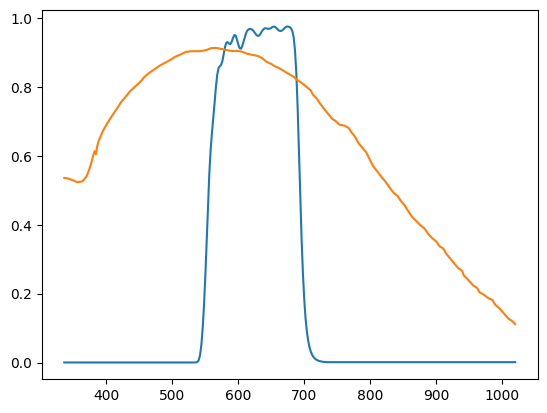

In [8]:
wavelengths = np.arange(336, 1022, 2)
sloan_r_file = '/Users/layden/Downloads/SLOAN.SDSS.rprime_filter.xml'
sloan_r = Table.read(sloan_r_file)
# Convert to numpy array
sloan_r = sloan_r.to_pandas()
sloan_r['Wavelength'] /= 10
# Interpolate the filter to find values at elements of wavelengths
sloan_r_interp = np.interp(wavelengths, sloan_r['Wavelength'], sloan_r['Transmission'])
cosmos_arr = np.genfromtxt('/Users/layden/Documents/Image-Sensor-Testing/data/cosmos_qe_datasheet.csv', delimiter=',')
cosmos_arr_interp = np.interp(wavelengths, cosmos_arr[:, 0], cosmos_arr[:, 1])
plt.plot(wavelengths, sloan_r_interp)
plt.plot(wavelengths, cosmos_arr_interp)
plt.show()

In [9]:
# Use Gaia spectra to calculate expected flux with our filter and QE
filename = '/Users/layden/Downloads/XpSampledMeanSpectrum_020748-020984.csv'
import pandas as pd
# Load csv into pandas dataframe
col_names = ['source_id', 'solution_id', 'ra', 'dec', 'flux', 'flux_err']
# Use 100 rows
df = pd.read_csv(filename, skiprows=64, names=col_names)
source_ids = df['source_id'].to_numpy()
# Want to convert Gaia fluxes to phot/m^2/nm/s. They're currently in W/m^2/nm
h = 6.62607015e-34  # Planck's constant in J s
c = 299792458  # Speed of light in m/s
# Create column in matched_catalog for fluxes
matched_catalog['gaia_phot_flux'] = np.zeros(len(matched_catalog), dtype=object)
for i, star in enumerate(matched_catalog):
    idx = np.where(source_ids == star['gaia_id'])[0]
    if len(idx) > 0:
        fluxes = df['flux'][idx[0]]
        # Convert fluxes string into numpy array. First remove brackets
        fluxes = fluxes[1:-1].split(',')
        fluxes = np.array(fluxes, dtype=float)
        phot_fluxes = fluxes / (h * c / (wavelengths * 1e-9))
        phot_fluxes = phot_fluxes * sloan_r_interp * cosmos_arr_interp
        tot_phot_flux = np.sum(phot_fluxes)
        matched_catalog['gaia_phot_flux'][i] = tot_phot_flux
# Exclude stars with no Gaia spectra
matched_catalog = matched_catalog[matched_catalog['gaia_phot_flux'] > 0]
print(matched_catalog)

       RA             Dec         Gmag  ...  BP-RP    gaia_phot_flux  
      deg             deg         mag   ...   mag                     
--------------- --------------- ------- ... ------- ------------------
 81.89007382196  36.30382169681 14.9690 ...  2.4590  4158.595315775276
 81.70567956686  36.02670085531 14.9375 ...  2.3186  4509.166174567016
 81.78574992913  36.25679350671 14.9572 ...  1.2529  5499.283522898514
 81.79795642730  36.01516016522 14.7937 ...  2.3550  5108.090179071825
 81.58666891446  35.98490619048 15.0136 ...  1.4332  5136.188331215109
 81.83442105536  36.28662297424 14.9886 ...  1.1066  5269.370313412286
 82.28759329720  35.72908410398 14.7586 ...  1.9994  5868.229904084428
 82.48554773513  36.17380883974 14.9980 ...  1.0644  5251.561448857335
 81.94879718718  36.03087076244 14.9598 ...  1.0912  5469.505833269925
 81.76533666136  35.78953868022 14.9263 ...  1.1967  5725.292763077851
            ...             ...     ... ...     ...                ...
 81.95

[  0.14413048 -82.52854502]


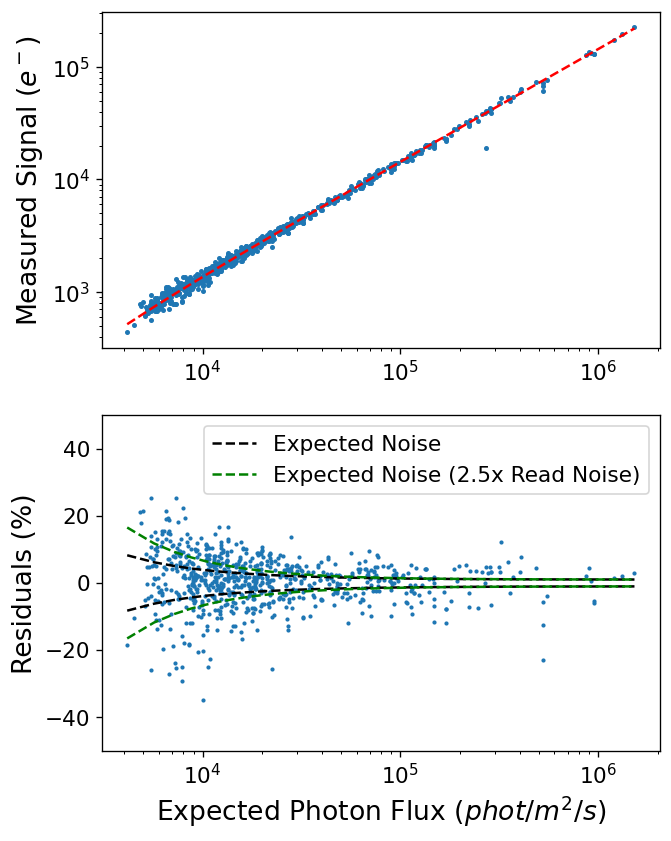

In [11]:
%matplotlib inline
# Increase resolution for plots
plt.rcParams['figure.dpi'] = 120
gain = 4.27
matched_catalog['meas_e_flux'] = matched_catalog['meas_flux'] / gain
# Convert Gmag to flux
matched_catalog['flux'] = 10 ** (-0.4 * (matched_catalog['gaia_phot_flux'] - 25.688365))
# plt.plot(matched_catalog['Gmag'], line(matched_catalog['Gmag'], *popt2), color='red')
# plt.ylim(0, 0.002)
# plt.show()

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
# Increase font size
plt.rcParams.update({'font.size': 13})
# Fit Gmag to measured flux
def func(x, a, b):
    return a * x + b
weights = np.ones(len(matched_catalog))
weights[:100] = 0.1
popt, _ = curve_fit(func, matched_catalog['gaia_phot_flux'], matched_catalog['meas_e_flux'], sigma=weights)
print(popt)
x = np.linspace(np.min(matched_catalog['gaia_phot_flux']), np.max(matched_catalog['gaia_phot_flux']), 1000)
# plt.gca().invert_xaxis()
ax[0].plot(matched_catalog['gaia_phot_flux'], matched_catalog['meas_e_flux'], 'o', markersize=2)
ax[0].plot(x, func(x, *popt), 'r--')
ax[0].set_ylabel(r'Measured Signal ($e^-$)', fontsize=16)
ax[1].set_xlabel(r'Expected Photon Flux ($phot/m^2/s$)', fontsize=16)
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# Calculate the residuals
matched_catalog['residuals'] = (matched_catalog['meas_e_flux'] - func(matched_catalog['gaia_phot_flux'], *popt)) / matched_catalog['meas_e_flux'] * 100
ax[1].plot(matched_catalog['gaia_phot_flux'], matched_catalog['residuals'], 'o', markersize=1.5)
# Plot residuals expected from shot noise
scint_noise_vals = func(x, *popt) * 0.01
aper_size = np.pi * 7 ** 2
read_noise = 2.6
read_noise_2 = read_noise * 2.5
mean_bkg = 1.5
tot_noise_vals = np.sqrt(func(x, *popt) + aper_size * (read_noise ** 2 + mean_bkg) + scint_noise_vals ** 2)
tot_noise_vals_2 = np.sqrt(func(x, *popt) + aper_size * (read_noise_2 ** 2 + mean_bkg) + scint_noise_vals ** 2)
tot_noise_vals_percent = tot_noise_vals / func(x, *popt) * 100
tot_noise_vals_percent_2 = tot_noise_vals_2 / func(x, *popt) * 100
ax[1].plot(x, tot_noise_vals_percent, 'k--', label='Expected Noise')
ax[1].plot(x, -tot_noise_vals_percent, 'k--')
ax[1].plot(x, tot_noise_vals_percent_2, 'g--', label='Expected Noise (2.5x Read Noise)')
ax[1].plot(x, -tot_noise_vals_percent_2, 'g--')
ax[1].set_ylabel('Residuals (%)', fontsize=16)
ax[1].legend()
ax[1].set_ylim(-50, 50)
ax[1].set_xscale('log')
plt.show()

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_50264/1016445872.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian_2d, (x, y), cutout.ravel(), p0=initial_guess)


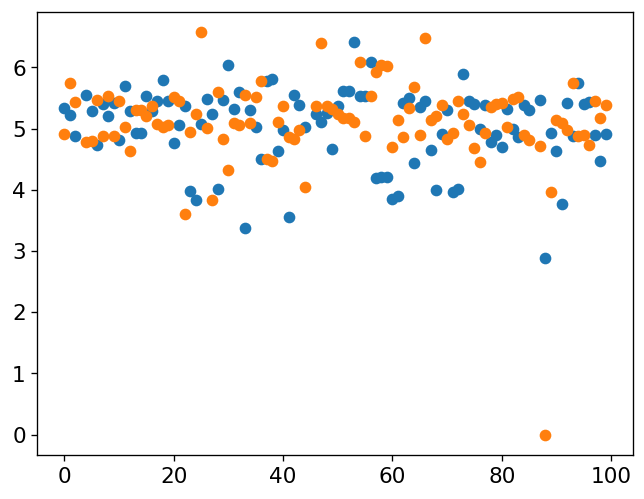

FWHM:  1.60 plus/minus 0.214 arcsec


In [11]:
# Take the 10 brightest stars. Make a 50x50 cutout around those stars and fit to a 2D Gaussian. Report the FWHM
brightest_stars = matched_catalog[-100:]
cutouts = []
for star in brightest_stars:
    xpos = star['xcentroid']
    ypos = star['ycentroid']
    cutout = data[int(ypos) - 25:int(ypos) + 25, int(xpos) - 25:int(xpos) + 25]
    cutouts.append(cutout)

def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """
    2D Gaussian function.
    """
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
    g = offset + amplitude * np.exp(-(a * (x - xo)**2 + 2*b * (x - xo) * (y - yo) + c * (y - yo)**2))
    return g.ravel()

def fit_gaussian_and_get_fwhm(cutout):
    """
    Fit a 2D Gaussian to a cutout and calculate the FWHM.
    """
    # Create coordinate grid
    x = np.arange(cutout.shape[1])
    y = np.arange(cutout.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Initial guesses for fitting
    amplitude = cutout.max() - cutout.min()
    xo, yo = np.unravel_index(np.argmax(cutout), cutout.shape)
    sigma_x = sigma_y = 3.0  # Initial guess for sigma
    theta = 0.0  # Assume no rotation
    offset = cutout.min()
    initial_guess = (amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
    
    try:
        # Fit the 2D Gaussian
        popt, _ = curve_fit(gaussian_2d, (x, y), cutout.ravel(), p0=initial_guess)
    except RuntimeError:
        return None  # Fit failed

    # Extract fitted parameters
    _, _, _, sigma_x, sigma_y, _, _ = popt

    # Calculate FWHM: FWHM = 2.355 * sigma
    fwhm_x = 2.355 * sigma_x
    fwhm_y = 2.355 * sigma_y
    if abs(fwhm_x) > 10 or abs(fwhm_y) > 10:
        return None

    return fwhm_x, fwhm_y

fwhm_results = np.zeros((len(cutouts), 2))
for i, cutout in enumerate(cutouts):
    result = fit_gaussian_and_get_fwhm(cutout)
    if result:
        fwhm_results[i] = result
    else:
        fwhm_results[i] = (None, None)

plt.plot(fwhm_results[:,0], 'o')
plt.plot(fwhm_results[:,1], 'o')
plt.show()
avg_fwhm = np.nanmean(fwhm_results) * wcs.pixel_scale_matrix[0, 0] * 3600
std_fwhm = np.nanstd(fwhm_results) * wcs.pixel_scale_matrix[0, 0] * 3600
print("FWHM: ", format(avg_fwhm, '3.2f'), "plus/minus", format(std_fwhm, '3.3f'), "arcsec")

In [12]:
# %matplotlib qt
# import matplotlib.pyplot as plt
# from astropy.visualization import simple_norm

# norm = simple_norm(data, 'log')
# # Make nans in data equal to zero
# plt.imshow(data, cmap='gray', norm=norm)
# plt.scatter(matched_catalog['xcentroid'], matched_catalog['ycentroid'], s=10, edgecolor='red', facecolor='none')
# # outliers = matched_catalog[abs(matched_catalog['residuals']) > 100]
# # print(outliers['RA', 'Dec', 'Gmag', 'meas_e_flux', 'residuals'])
# # plt.scatter(outliers['xcentroid'], outliers['ycentroid'], s=30, edgecolor='red', facecolor='none')
# plt.title('COSMOS Image of M38 with Gaia Stars')
# plt.show()

In [13]:
def shift_values(arr, del_x, del_y):
    '''Shift values in an array by a specified discrete displacement.
    
    Parameters
    ----------
    arr : array-like
        The intensity grid.
    del_x : int
        The x displacement, in subpixels.
    del_y : int
        The y displacement, in subpixels.
        
    Returns
    -------
    new_arr : array-like
        The shifted array.
    '''
    n, m = arr.shape
    new_arr = np.zeros_like(arr)
    # print(abs(del_x) > m, abs(del_y) > n)
    new_arr[max(del_y, 0):m+min(del_y, 0), max(del_x, 0):n+min(del_x, 0)] = \
        arr[-min(del_y, 0):m-max(del_y, 0), -min(del_x, 0):n-max(del_x, 0)]
    return new_arr

In [ ]:
source_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/Light Curve'
stacks = get_stacks(source_folder)[1:]

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/On Sky Data/Light Curve/calibrated_CMS_RS_M38_r_filter1000ms_-25C 2024 November 01 08_17_05.fits


In [15]:
# Concatenate imagestacks into a single array
imagestack = np.concatenate([stack['imagestack'] for stack in stacks], axis=0)
print(0)
imagestack = imagestack.astype(np.float32)
print(1)
# Remove defect pixels
imagestack = imagestack * defect_data_1 * defect_data_2
print(2)

0
1
2


In [16]:
subarray_size = 200
start_x, start_y = 1168, 3697
shift_x, shift_y = 0, 0

In [20]:
test_cube = np.zeros((len(imagestack), 200, 200))
shifts = np.zeros((len(imagestack), 2))
for i in range(len(imagestack)):
    print('Starting Frame', i)
    frame = imagestack[i]
    start_x -= shift_x
    start_y -= shift_y
    # Clear previous stack_data from memory
    # subarray_dark = dark_data_avg[start_y - subarray_size // 2:start_y + subarray_size // 2,
    #                            start_x - subarray_size // 2:start_x + subarray_size // 2]
    # subarray_flat = flat_field[start_y - subarray_size // 2:start_y + subarray_size // 2,
    #                            start_x - subarray_size // 2:start_x + subarray_size // 2]
    subarray_data = frame[start_y - subarray_size // 2:start_y + subarray_size // 2,
                        start_x - subarray_size // 2:start_x + subarray_size // 2]
    subarray_data = np.nan_to_num(subarray_data, nan=106)
    # subarray_data = (subarray_data - subarray_dark) / subarray_flat
    max_index = np.argmax(subarray_data)
    max_coords = np.unravel_index(max_index, subarray_data.shape)
    
    y, x = np.mgrid[:subarray_data.shape[0], :subarray_data.shape[1]]
    initial_guess = models.Gaussian2D(amplitude=subarray_data.max(), x_mean=max_coords[1], y_mean=max_coords[0], x_stddev=3, y_stddev=3)
    fitter = fitting.LevMarLSQFitter()
    fitted_gaussian = fitter(initial_guess, x, y, subarray_data)
    shift_x = np.rint(subarray_size / 2 - fitted_gaussian.x_mean.value).astype(int)
    shift_y = np.rint(subarray_size / 2 - fitted_gaussian.y_mean.value).astype(int)
    print(start_x, start_y, shift_x, shift_y)
    shifted_frame = shift_values(subarray_data, shift_x, shift_y)
    test_cube[i] = shifted_frame
    shifts[i] = (start_x - shift_x, start_y - shift_y)
shifts = (shifts - shifts[0]).astype(int)

Starting Frame 0
1168 3697 7 0
Starting Frame 1
1161 3697 0 1
Starting Frame 2
1161 3696 0 -1
Starting Frame 3
1161 3697 0 1
Starting Frame 4
1161 3696 0 -1
Starting Frame 5
1161 3697 0 0
Starting Frame 6
1161 3697 -1 0
Starting Frame 7
1162 3697 -1 0
Starting Frame 8
1163 3697 1 0
Starting Frame 9
1162 3697 0 0
Starting Frame 10
1162 3697 -1 0
Starting Frame 11
1163 3697 1 1
Starting Frame 12
1162 3696 0 0
Starting Frame 13
1162 3696 -1 -1
Starting Frame 14
1163 3697 0 0
Starting Frame 15
1163 3697 0 0
Starting Frame 16
1163 3697 1 0
Starting Frame 17
1162 3697 0 1
Starting Frame 18
1162 3696 0 0
Starting Frame 19
1162 3696 -1 0
Starting Frame 20
1163 3696 0 0
Starting Frame 21
1163 3696 -1 0
Starting Frame 22
1164 3696 0 0
Starting Frame 23
1164 3696 0 -1
Starting Frame 24
1164 3697 0 0
Starting Frame 25
1164 3697 0 0
Starting Frame 26
1164 3697 0 1
Starting Frame 27
1164 3696 0 0
Starting Frame 28
1164 3696 -1 0
Starting Frame 29
1165 3696 0 -1
Starting Frame 30
1165 3697 1 0
Starti

In [21]:
%matplotlib qt
for i in range (len(imagestack)):
    print('Starting Frame', i)
    frame = (imagestack[i] - dark_data_avg) / flat_field + 100
    frame = shift_values(frame, -shifts[i, 0], -shifts[i, 1])
    imagestack[i] = frame
mean_shifted_img = np.mean(imagestack, axis=0)
plt.imshow(mean_shifted_img, cmap='gray', norm='log')
plt.show()

Starting Frame 0
Starting Frame 1
Starting Frame 2
Starting Frame 3
Starting Frame 4
Starting Frame 5
Starting Frame 6
Starting Frame 7
Starting Frame 8
Starting Frame 9
Starting Frame 10
Starting Frame 11
Starting Frame 12
Starting Frame 13
Starting Frame 14
Starting Frame 15
Starting Frame 16
Starting Frame 17
Starting Frame 18
Starting Frame 19
Starting Frame 20
Starting Frame 21
Starting Frame 22
Starting Frame 23
Starting Frame 24
Starting Frame 25
Starting Frame 26
Starting Frame 27
Starting Frame 28
Starting Frame 29
Starting Frame 30
Starting Frame 31
Starting Frame 32
Starting Frame 33
Starting Frame 34
Starting Frame 35
Starting Frame 36
Starting Frame 37
Starting Frame 38
Starting Frame 39
Starting Frame 40
Starting Frame 41
Starting Frame 42
Starting Frame 43
Starting Frame 44
Starting Frame 45
Starting Frame 46
Starting Frame 47
Starting Frame 48
Starting Frame 49


In [ ]:
# %matplotlib qt
# test_cube2 = image_cube[:,5531:5731,5341:5541]
# fig, ax = plt.subplots()
# im = ax.imshow(test_cube2[0], cmap='gray')

# def update(frame):
#     im.set_array(test_cube2[frame])
#     return [im]

# ani = animation.FuncAnimation(fig, update, frames=len(test_cube2), interval=100, blit=True)
# plt.show()

In [ ]:
# %matplotlib qt
# fig, ax = plt.subplots()
# im = ax.imshow(test_cube[0], cmap='gray')

# def update(frame):
#     im.set_array(test_cube[frame])
#     return [im]

# ani = animation.FuncAnimation(fig, update, frames=len(test_cube), interval=100, blit=True)
# plt.show()

In [78]:
%matplotlib inline
subarray_size = 100
positions = [(subarray_size // 2, subarray_size // 2)]  # Center of the subarray

# Define the aperture
aperture = CircularAperture(positions, r=10)
annulus = CircularAnnulus(positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
# Perform background photometry using annuli
annulus_mask = annulus.to_mask(method='center')

# Create mask to calculate background
source_mask = aperture.to_mask(method='exact')[0].to_image((subarray_size, subarray_size))
source_mask = source_mask.astype(bool)

# Perform aperture photometry on each frame in the image cube
light_curves = np.zeros((len(matched_catalog), len(imagestack)))

# Make the light curves for stars in the matched catalog with increasing brightness

for j, star in enumerate(matched_catalog):
    xpos = np.rint(star['xcentroid']).astype(int)
    ypos = np.rint(star['ycentroid']).astype(int)
    for i in range(len(imagestack)):
        frame = imagestack[i].astype(float)
        subarray = frame[ypos - subarray_size // 2:ypos + subarray_size // 2,
                          xpos - subarray_size // 2:xpos + subarray_size // 2]
        subarray = np.nan_to_num(subarray, nan=106)
        annulus_data = annulus_mask[0].multiply(subarray)
        annulus_data_1d = annulus_data[annulus_mask[0].data > 0]  # Exclude zero-padding
        # Ignore warning for clipping NaNs
        _, median_background, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.0)
        subarray -= median_background
        # bkg = Background2D(subarray, (subarray_size, subarray_size), filter_size=(3, 3),
        #                 bkg_estimator=MedianBackground(), mask=source_mask)
        # subarray -= bkg.background
        phot_table = aperture_photometry(subarray, aperture)
        light_curves[j, i] = phot_table['aperture_sum'][0]
        print(j, i, light_curves[j, i])


0 0 2495.477372892323
0 1 2126.8779007578833
0 2 2786.7447653881227
0 3 2542.6847923465184
0 4 1641.3001261158993
0 5 2557.400479642201
0 6 2122.4906017281055
0 7 1880.9429458273607
0 8 3311.5558438775042
0 9 2860.3362253049954
0 10 1952.2961704963993
0 11 2675.6757122739973
0 12 2602.602158063253
0 13 2819.6414621769
0 14 2668.2929588008483
0 15 3951.3187460844765
0 16 1415.1171621325323
0 17 2814.120439003863
0 18 2169.0189478510106
0 19 2845.160067675837
0 20 2875.7256966498235
0 21 1998.3447374339153
0 22 2715.04113088699
0 23 2330.852995357658
0 24 2723.1440050086458
0 25 2381.2189156779705
0 26 2950.271247774728
0 27 3854.9529617365542
0 28 2720.01862617522
0 29 2979.412217149091
0 30 2906.158314020543
0 31 3192.7751224572276
0 32 2918.9564857126006
0 33 1452.1723286322356
0 34 2421.317702927003
0 35 2425.8405906794364
0 36 1969.7413263487572
0 37 3314.5480983413463
0 38 1694.1914800377992
0 39 1942.4484338328516
0 40 3159.267739890567
0 41 2868.9304754991
0 42 2225.888896627752


In [ ]:
# gain = 4.06
# light_curves = light_curves[:91] / gain
# Get rid of element 6
# light_curves = np.delete(light_curves, 6, axis=0)

In [12]:
# Concatenate the light curves
avg_brightnesses = np.mean(light_curves[:], axis=0) / np.mean(light_curves[:])
light_curves_2 = light_curves / avg_brightnesses
light_curves_2 = light_curves_2 / gain
light_curve_means = np.mean(light_curves_2, axis=1)
light_curve_errs = np.std(light_curves_2, axis=1) / light_curve_means
plt.plot(light_curve_means, light_curve_errs, 'o', markersize=2, label='Measured Data')
mean_points = np.linspace(500, 70000, 100)
shot_noise_points = 1 / np.sqrt(mean_points)
scint_noise_points = 0.005 * np.ones_like(mean_points)
read_noise_points = read_noise * np.sqrt(10 ** 2 * np.pi) / mean_points
bkg_noise_points = np.sqrt(aper_size * mean_bkg) / mean_points
tot_noise_points = np.sqrt(shot_noise_points ** 2 + read_noise_points ** 2 + bkg_noise_points ** 2 + scint_noise_points ** 2)
plt.plot(mean_points, shot_noise_points, 'r', linestyle='dotted', label='Shot Noise')
plt.plot(mean_points, scint_noise_points, 'g--', label='Scintillation Noise')
plt.plot(mean_points, read_noise_points, 'm--', label='Read Noise')
plt.plot(mean_points, bkg_noise_points, 'b-.', label='Background Noise')
plt.plot(mean_points, tot_noise_points, 'k-', label='Total Noise')
plt.legend(fontsize=10)
plt.xlabel('Mean Signal (e-)', fontsize=16)
plt.ylabel('Noise-to-Signal Ratio (%)', fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.xlim(500, 30000)
plt.ylim(0.001, 0.4)
plt.show()

NameError: name 'light_curves' is not defined

2641.430742530593 21.81616860151535 2.654852758275677
2249.5625962817144 26.032681111064083 2.8979209978069553
2915.3048735317443 23.22757836812172 2.523145673491775
3075.03370627209 21.552983221159984 2.4569695676576324
2939.8029573303 23.22075599635871 2.5125383489314723
3199.290962750539 16.94502572581305 2.4099729859165664
3496.533901188082 20.799179754255714 2.3108475193360456
3085.891907836643 18.652984893398454 2.452714891076281
3313.49280830665 17.13874608494605 2.369827924148954
3473.714562581964 17.23894976687473 2.3178682227684395


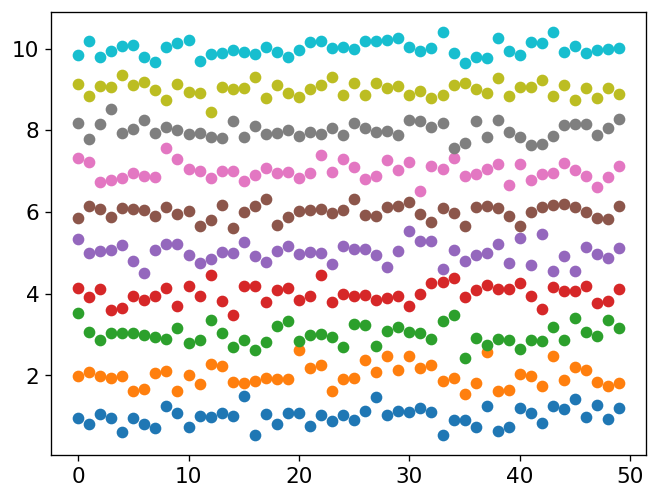

In [69]:
for i in range(10):
    light_curve = light_curves[i]
    mean_electron_flux = np.mean(light_curve)
    expected_noise = np.sqrt(mean_electron_flux + aper_size * (read_noise ** 2 + mean_bkg) + (0.012 * mean_electron_flux) ** 2) / mean_electron_flux * 100
    meas_noise = np.std(light_curve) / mean_electron_flux * 100
    print(mean_electron_flux, meas_noise, expected_noise)
    plt.plot(i + light_curve / np.mean(light_curve), 'o')
plt.show()

In [79]:
# Perform aperture photometry on each frame in the image cube
light_curves_low = np.zeros((len(aperture_photometry_result), len(imagestack)))

# Make the light curves for stars in the matched catalog with increasing brightness

for j, star in enumerate(aperture_photometry_result):
    xpos = np.rint(star['xcenter'] / u.pix).astype(int)
    ypos = np.rint(star['ycenter'] / u.pix).astype(int)
    for i in range(len(imagestack)):
        frame = imagestack[i].astype(float)
        subarray = frame[ypos - subarray_size // 2:ypos + subarray_size // 2,
                          xpos - subarray_size // 2:xpos + subarray_size // 2]
        subarray = np.nan_to_num(subarray, nan=106)
        annulus_data = annulus_mask[0].multiply(subarray)
        annulus_data_1d = annulus_data[annulus_mask[0].data > 0]  # Exclude zero-padding
        # Ignore warning for clipping NaNs
        _, median_background, _ = sigma_clipped_stats(annulus_data_1d, sigma=3.0)
        subarray -= median_background
        # bkg = Background2D(subarray, (subarray_size, subarray_size), filter_size=(3, 3),
        #                 bkg_estimator=MedianBackground(), mask=source_mask)
        # subarray -= bkg.background
        phot_table = aperture_photometry(subarray, aperture)
        light_curves_low[j, i] = phot_table['aperture_sum'][0]
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

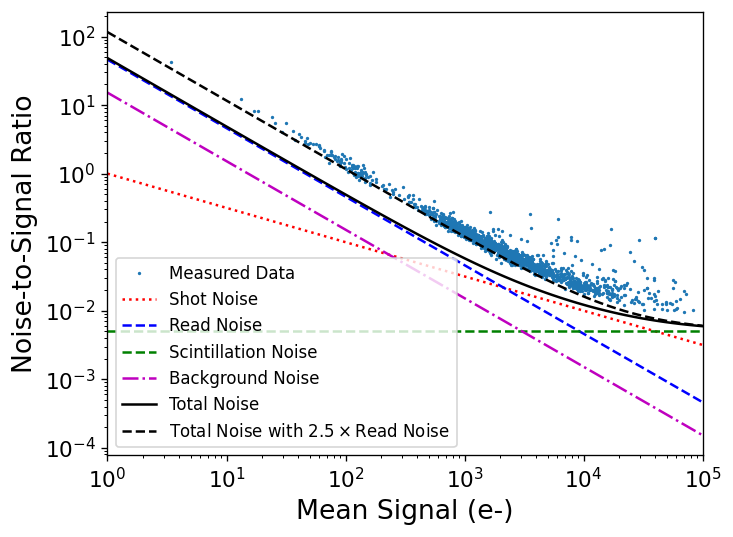

In [138]:
# Concatenate the light curves
read_noise = 2.6
avg_brightnesses = np.mean(light_curves_low, axis=0) / np.mean(light_curves_low)
light_curves_2 = light_curves_low / avg_brightnesses
light_curves_2 = light_curves_2 / gain
light_curve_means = np.mean(light_curves_2, axis=1)
light_curve_errs = np.std(light_curves_2, axis=1) / light_curve_means
plt.plot(light_curve_means, light_curve_errs, 'o', markersize=1, label='Measured Data')
mean_points = np.logspace(0, 5, 100)
shot_noise_points = 1 / np.sqrt(mean_points)
scint_noise_points = 0.005 * np.ones_like(mean_points)
read_noise_points = read_noise * np.sqrt(10 ** 2 * np.pi) / mean_points
bkg_noise_points = np.sqrt(aper_size * mean_bkg) / mean_points
tot_noise_points = np.sqrt(shot_noise_points ** 2 + read_noise_points ** 2 + bkg_noise_points ** 2 + scint_noise_points ** 2)
tot_noise_points_2 = np.sqrt(shot_noise_points ** 2 + (read_noise_points * 2.5) ** 2 + bkg_noise_points ** 2 + scint_noise_points ** 2)
plt.plot(mean_points, shot_noise_points, 'r', linestyle='dotted', label='Shot Noise')
plt.plot(mean_points, read_noise_points, 'b--', label='Read Noise')
plt.plot(mean_points, scint_noise_points, 'g--', label='Scintillation Noise')
plt.plot(mean_points, bkg_noise_points, 'm-.', label='Background Noise')
plt.plot(mean_points, tot_noise_points, 'k-', label='Total Noise')
plt.plot(mean_points, tot_noise_points_2, 'k--', label=r'Total Noise with $2.5\times$Read Noise')
plt.legend(fontsize=10, loc='lower left')
plt.xlabel('Mean Signal (e-)', fontsize=16)
plt.ylabel('Noise-to-Signal Ratio', fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1, 100000)
# plt.ylim(0.001, 0.4)
plt.show()

In [88]:
1/np.sqrt(10.)

0.31622776601683794